# 空间数据的探索性分析：空间自相关 #


在本笔记本中，我们介绍_探索性空间数据分析_的方法
旨在通过正式的单变量和
空间聚类的多变量统计检验。


## Imports

In [81]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

我们的数据集来自 2018 年 4 月拍摄的柏林爱彼迎抓取信息。该数据框是由 [Levi Wolf](https://ljwolf.org) 和 [Serge Rey](https://sergerey.org)。 作为研讨会的一部分，我们构建了一个 geopandas 数据框架，其中一列报告了柏林每个社区的单位挂牌价格中位数：

In [82]:
gdf = gpd.read_file('data/berlin-neighbourhoods.geojson')


In [83]:
bl_df = pd.read_csv('data/berlin-listings.csv')
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
crs = {'init': 'epsg:4326'} 
bl_gdf = GeoDataFrame(bl_df, crs=crs, geometry=geometry)


In [84]:
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_gb

neighbourhood_group
Charlottenburg-Wilm.        58.556408
Friedrichshain-Kreuzberg    55.492809
Lichtenberg                 44.584270
Marzahn - Hellersdorf       54.246754
Mitte                       60.387890
Neukölln                    45.135948
Pankow                      60.282516
Reinickendorf               43.682465
Spandau                     48.236561
Steglitz - Zehlendorf       54.445683
Tempelhof - Schöneberg      53.704407
Treptow - Köpenick          51.222004
Name: price, dtype: float32

In [85]:
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)
gdf.head(15)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...",51.222004
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...",51.222004
5,Biesdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.56643 52.53510, 13.56697 52...",54.246754
6,Nord 1,Reinickendorf,"MULTIPOLYGON (((13.33669 52.62265, 13.33663 52...",43.682465
7,West 5,Reinickendorf,"MULTIPOLYGON (((13.28138 52.59958, 13.28158 52...",43.682465
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,"MULTIPOLYGON (((13.45320 52.51682, 13.45321 52...",55.492809
9,Buch,Pankow,"MULTIPOLYGON (((13.46449 52.65055, 13.46457 52...",60.282516


我们首先要处理一个“nan”：

In [86]:
pd.isnull(gdf['median_pri']).sum()

2

In [87]:
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)

<Axes: >

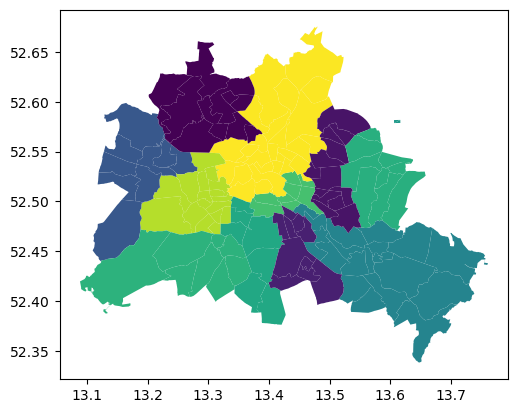

In [88]:
gdf.plot(column='median_pri')

<Axes: >

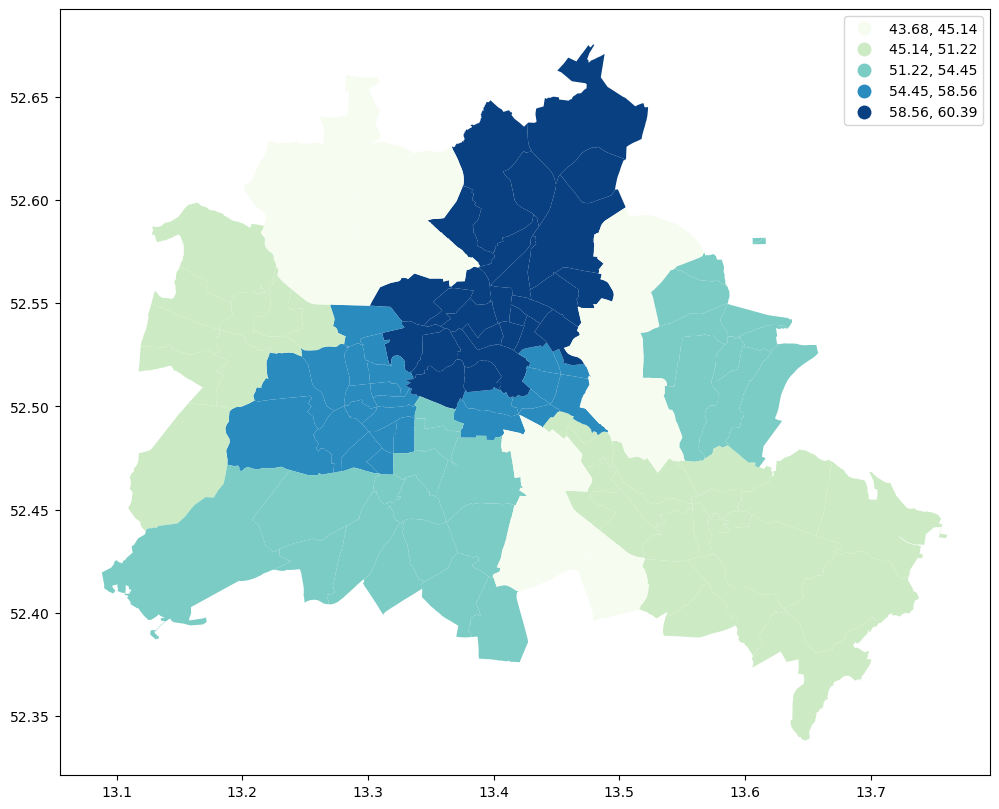

In [89]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)

## 空间自相关 ##

目视检查价格的地图图案使我们能够搜索空间结构。 如果价格的空间分布是随机的，那么我们在地图上不应看到任何类似值的聚类。 然而，我们的视觉系统被西南和中心的较暗星团所吸引，浅色调（较低的价格）集中在中北部和东南。

我们的大脑是非常强大的模式识别机器。 然而，有时它们可能过于强大，导致我们检测到误报或模式没有统计模式的地方。 这是一个特别值得关注的问题处理不同大小和形状的不规则多边形的可视化。

*空间的概念
自相关*涉及两种相似性的组合：空间相似性相似度和属性相似度。 虽然有很多不同的措施空间自相关性，它们都将这两种类型的相似性结合起来一项总结措施。

让我们使用 PySAL 生成这两种类型的相似度措施。

### 空间相似度###

我们已经遇到过空间权重在之前的笔记本里。 在空间自相关分析中，空间权重用于形式化空间相似性的概念。 正如我们在那里看到的定义空间权重的方法有很多种，这里我们将使用皇后连续性：

In [90]:
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

### 属性相似度 ###

因此，邻域 $i$ 和 $j$ 之间的空间权重表明这两个邻域是否
是邻居（即地理位置相似）。 我们还需要衡量
属性相似性与空间相似性的概念相匹配。 这
**空间滞后**是一个派生变量，可以为我们完成此任务。 对于邻里
$i$ 空间滞后定义为： $$ylag_i = \sum_j w_{i,j} y_j$$

In [91]:
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

In [92]:
ylag

array([56.9625061 , 60.28251648, 56.37749926, 51.22200394, 51.22200394,
       50.52180099, 43.6824646 , 45.63422012, 52.65491422, 60.28251648,
       53.64180374, 52.73586273, 52.73586273, 56.47182541, 47.83247757,
       58.58870177, 60.33520317, 59.60296903, 60.38788986, 60.02159348,
       51.80624199, 57.94034958, 52.84482813, 53.40314266, 57.90522512,
       60.28251648, 60.28251648, 55.79730334, 56.79401737, 50.81182589,
       59.01427841, 60.29756982, 60.28251648, 50.86356888, 60.3220315 ,
       60.28251648, 55.48057556, 54.42881557, 60.32466583, 59.50179418,
       54.42846909, 58.55640793, 58.55640793, 57.73426285, 57.47818544,
       57.74774106, 56.13040733, 48.23656082, 48.23656082, 53.74621709,
       55.11957245, 45.95951271, 51.67650986, 54.1985906 , 51.45368042,
       52.36880302, 54.44568253, 54.44568253, 50.84825389, 56.50104523,
       53.92108345, 55.9956289 , 50.49590378, 49.14499828, 48.61369433,
       49.70049   , 49.32550866, 51.22200394, 51.22200394, 47.80

In [93]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

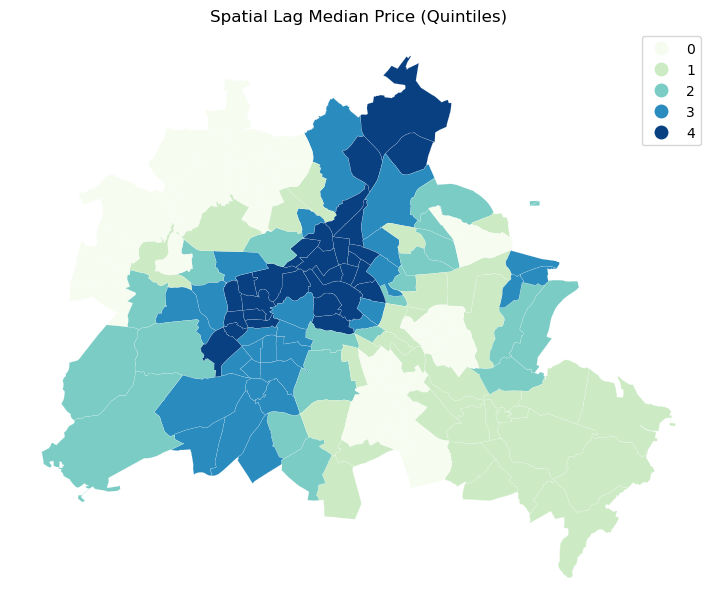

In [94]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

空间滞后的五分位图往往会增强价值印象
空间上的相似性。 实际上，它是一个局部平滑器。

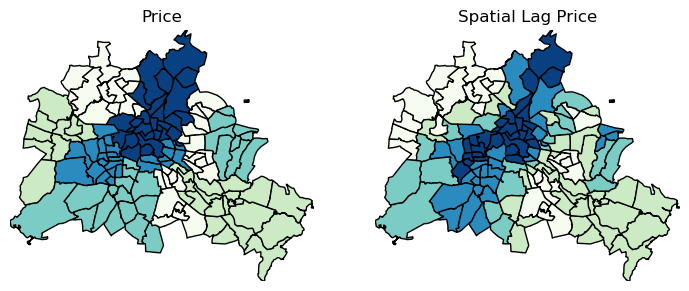

In [95]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

然而，我们仍然有
在视觉上关联邻近地区的价格价值的挑战
与焦点单位值的空间滞后值。 后者是一个
重点县附近标价的加权平均值。

为了补充这些协会的地理可视化，我们可以求助于正式的
空间自相关的统计测量。


## 全局空间自相关

我们从一个简单的情况开始，其中所考虑的变量是二进制的。
这对于解开空间自相关测试的逻辑很有用。 所以尽管
我们的属性是一个连续值的属性，我们将其转换为二进制情况
说明关键概念：

### 二进制大小写

In [96]:
y.median()


53.704407

In [97]:
yb = y > y.median()
sum(yb)

68

我们有 68 个街区的标价高于中位数，70 个街区低于中位数
中位数（回想一下领带问题）。

In [98]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

二元变量的空间分布立即引发了问题
关于“黑”和“白”区域的并置。

<Axes: >

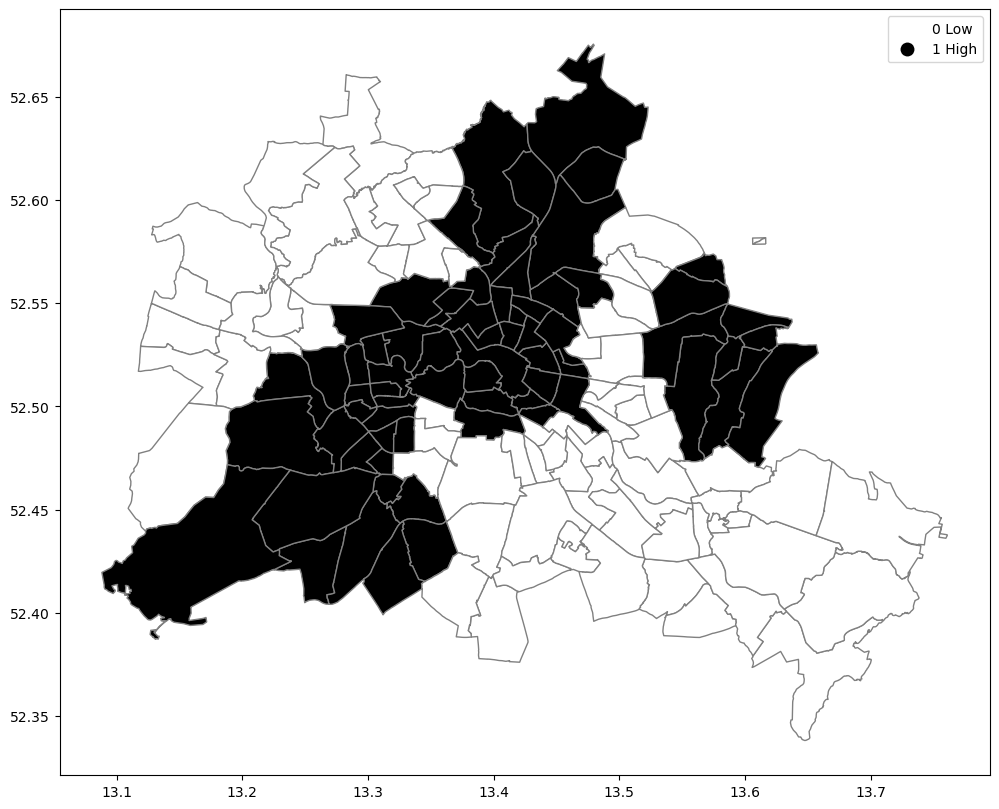

In [99]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### 加入计数 ###

形式化二元属性中空间自相关检验的一种方法是
考虑所谓的_joins_。 每个邻居对都存在一个连接
观察，并且连接反映在我们的二元空间权重对象中
`wq`。

每个单位可以采用“黑色”或“白色”两个值之一，因此对于给定的
一对相邻位置存在三种不同类型的连接，可以
出现：

- 黑黑 (BB)
- 白色 白色 (WW)
- 黑白（或白黑）（BW）

假设我们的地图上有 68 个黑色多边形，那么黑色多边形的数量是多少？
如果过程是这样的，那么我们可以预期黑色（BB）加入
多边形是随机分配在地图上的吗？ 这就是join count统计的逻辑。

我们可以使用 PySAL 中的 esda 包来进行连接计数分析：

In [100]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

结果对象存储不同类型连接的观察计数：

In [101]:
jc.bb

164.0

In [102]:
jc.ww

149.0

In [103]:
jc.bw

73.0

请注意，这三种情况穷尽了所有可能性：

In [104]:
jc.bb + jc.ww + jc.bw

386.0

and

In [105]:
wq.s0 / 2

386.0

这是空间权重对象中唯一的连接数。

我们的对象告诉我们已经观察到 164 个 BB 连接：

In [106]:
jc.bb

164.0

对我们来说，关键问题是这是否背离了我们的初衷
期望该过程是否生成黑色多边形的空间分布
是完全随机的吗？ 为了回答这个问题，PySAL 使用随机空间
观察到的属性值的排列以生成下一个实现
_完全空间随机性_ (CSR) 为空。 这是大量重复的
构建参考分布以评估的次数（默认为 999）
我们观察到的计数的统计显着性。

综合实现中 BB 连接的平均数量为：

In [107]:
jc.mean_bb

90.70170170170171

这比我们观察到的数量要少。 问题是我们是否观察到
价值与期望相差如此之大以至于我们会拒绝CSR的无效性？

Text(0.5, 0, 'BB Counts')

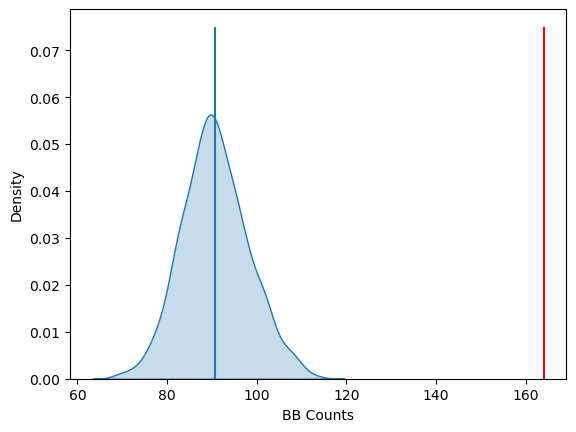

In [108]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')


密度描绘了 BB 计数的分布，黑色垂直
线表示合成实现中的平均 BB 计数和红色
将观察到的 BB 计数划线为我们的价格。 显然我们观察到的值为
极高。 伪 p 值总结了这一点：

In [109]:
jc.p_sim_bb


0.001

由于这低于传统的显着性水平，我们将拒绝零值
完全的空间随机性有利于市场价格的空间自相关。


### 连续案例

连接计数分析基于二元属性，可以覆盖很多
有趣的实证应用，人们对存在和存在感兴趣
缺席型现象。 在我们的例子中，我们人为地创建了二进制变量，
在这个过程中我们丢掉了很多原来的信息
连续属性。 回到原来的变量，我们可以探索
连续情况的空间自相关的其他检验。

首先，我们将权重从当前的二进制状态转换为行标准化：

In [110]:
wq.transform = 'r'

In [111]:
y = df['median_pri']

Moran's I 是对连续属性的全局自相关性的检验：

In [112]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6563069331329718

同样，我们的统计值需要根据参考来解释
CSR无效下的分配。 PySAL 使用与我们在中看到的类似的方法
连接计数分析：随机空间排列。

Text(0.5, 0, "Moran's I")

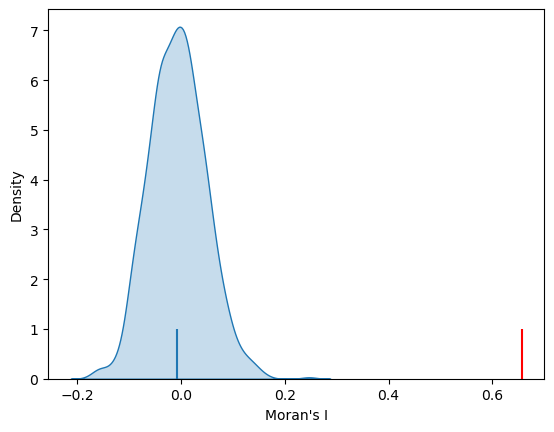

In [113]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


这里我们观察到的值再次位于上尾部，尽管从视觉上看确实如此
相对于二进制情况看起来并不极端。 然而，它仍然具有统计显着性：

In [114]:
mi.p_sim

0.001

## 局部自相关：热点、冷点和空间异常值 ##

除了全局自相关统计之外，PySAL 还有很多局部自相关统计
自相关统计。 让我们计算相同的局部 Moran 统计量
d

In [115]:
np.random.seed(12345)
import esda

In [116]:
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])


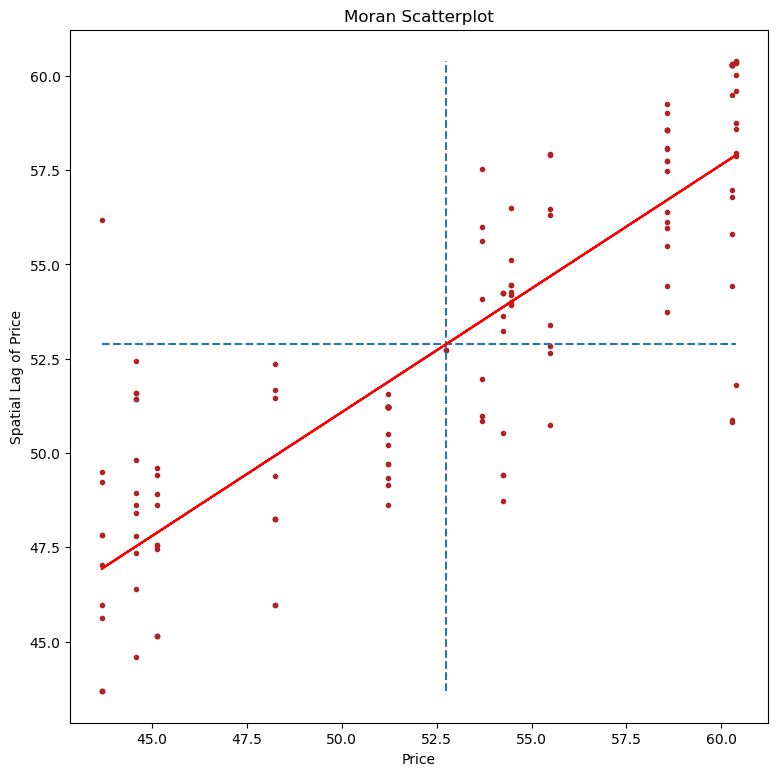

In [117]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


现在，我们有一个本地 $I_i$ 的*数组*，而不是单个 $I$ 统计数据
统计数据存储在“.Is”属性中，模拟的 p 值是
在“p_sim”中。

In [118]:
li = esda.moran.Moran_Local(y, wq)

In [119]:
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 4, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

我们可以再次使用排列来测试局部聚类，但这里我们使用
条件随机排列（每个焦点位置的不同分布）

In [120]:
(li.p_sim < 0.05).sum()

68

我们可以区分反映在局部空间关联的具体类型
上面莫兰散点图的四个象限：

In [121]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [122]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

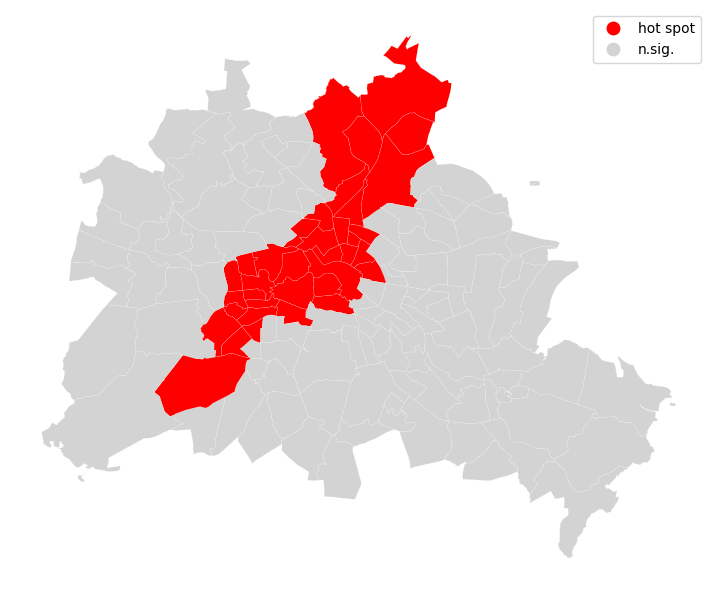

In [123]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [124]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

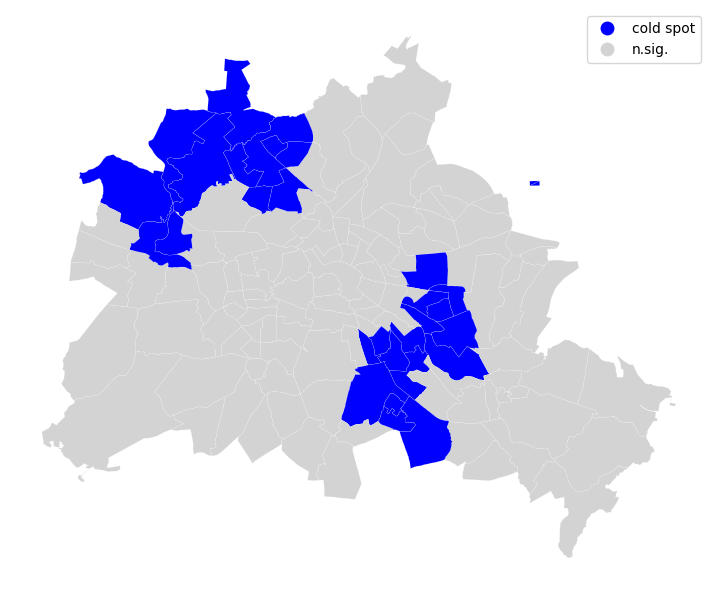

In [125]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [126]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

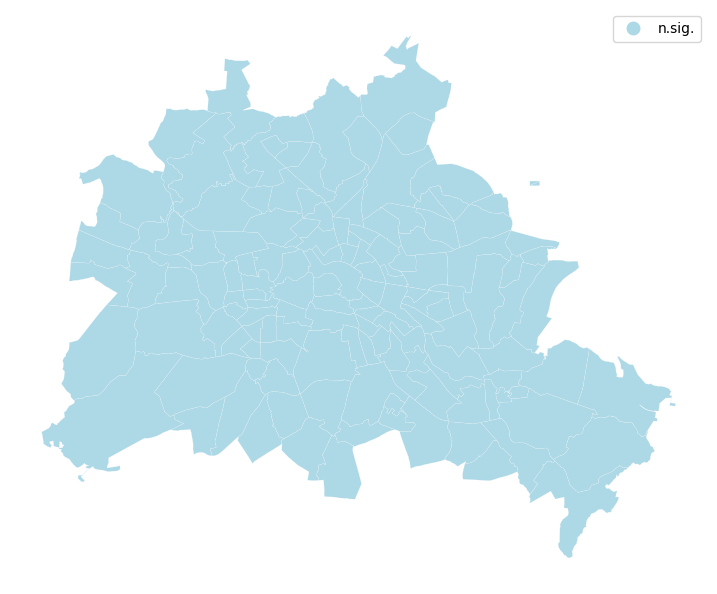

In [127]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [128]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

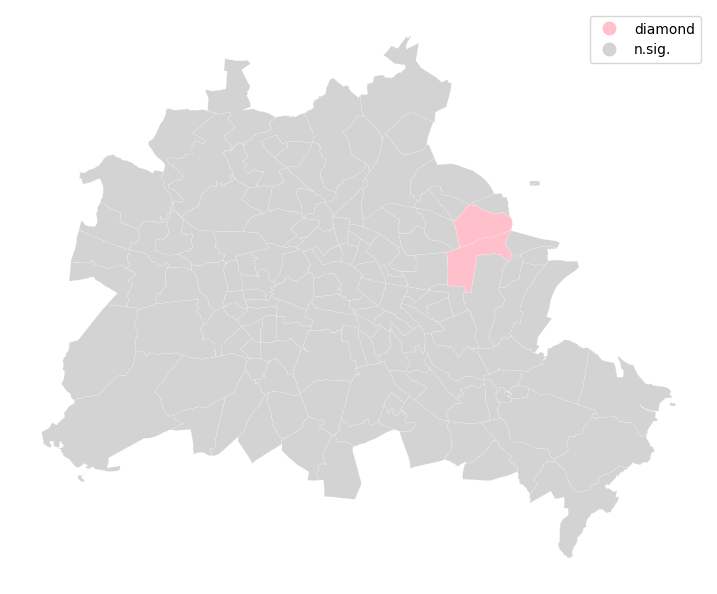

In [129]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [130]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0,
       3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0,
       0, 3, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 3, 0, 0, 3, 0,
       1, 1, 1, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 3, 3])

In [131]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

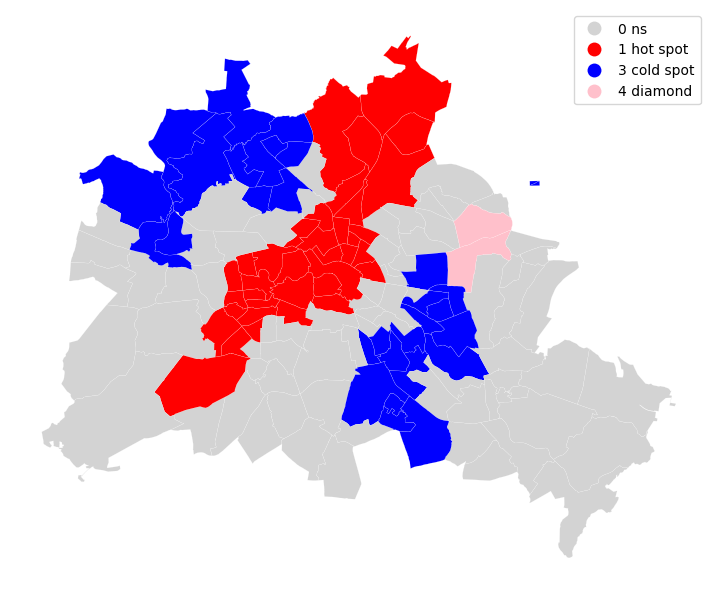

In [132]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()